<a href="https://colab.research.google.com/github/TheCoreMan13/NLP-Leibniz-Clarke-Letters/blob/main/Leibniz_Clarke_Letters_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modules**

In [ ]:
import nltk
nltk.download('all')
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import string
import re

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

# **Import Leibniz-Clarke Letters**

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('/content/Leibniz-Clarke Letters.xml')
root = tree.getroot()

#Transform the letter in string
df = ET.tostring(root, encoding='utf8').decode('utf8')
# print(df)


final_tokens = word_tokenize(df)
print(df)

# **POS (Parts Of Speech) settings**

In [ ]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

# **Remove stopwords, Tokenize sentences and words, use stemmer & lemmatizer**

In [ ]:
from nltk import word_tokenize, pos_tag
# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('utterance')
stopwords.append('ref')
stopwords.append('genid')
stopwords.append ('clarke')
stopwords.append ('thing')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
print(df)
# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,text in enumerate(final_tokens):
    # Tokenize by sentence, then by lowercase word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        t = remove_accents(token)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)
        
        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t):
                if len(t) >= MIN_STR_LEN:
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]
                    
                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS
                    
                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)
    
    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)
    
# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)


# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])


## Find the most popular concepts and group results by Part of Speech (POS)

In [ ]:
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
print("df_words.head(7):")
print(df_words.head(7))
print(len((df_words)))

df_words.head(7):
      lem  index      token    stem pos  counts
0     god     39        god     god  NN     206
1   space     51      space   space  NN     142
2   thing     56     things   thing  NN     119
3    body     16       body    bodi  NN      80
4  reason    417  reasoning  reason  VB      74
5  matter     36     matter  matter  NN      72
6   world    110      world   world  NN      69
1398


## Top 7 words per Part Of Speech (POS)

In [ ]:
df_words = df_words[['lem', 'pos', 'counts']].head(200)
for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
    print()
    print("POS_TYPE:", v)
    print(df_pos.head(7).to_string())


POS_TYPE: NN
      lem pos  counts
0     god  NN     206
1   space  NN     142
2   thing  NN     119
3    body  NN      80
5  matter  NN      72
6   world  NN      69
7    soul  NN      56

POS_TYPE: JJ
             lem pos  counts
30          real  JJ      28
33         empty  JJ      27
42       natural  JJ      22
52  mathematical  JJ      20
54          much  JJ      20
64          true  JJ      17
66       eternal  JJ      17

POS_TYPE: VB
       lem pos  counts
4   reason  VB      74
8     make  VB      55
10     say  VB      52
20    move  VB      36
25    give  VB      33
51   point  VB      20
60    take  VB      19

POS_TYPE: RB
          lem pos  counts
31       mere  RB      27
34     rather  RB      27
35       even  RB      26
50       also  RB      21
58       well  RB      19
59    exactly  RB      19
70  perfectly  RB      16


# **Frequency plot for concepts**

[('god', 206), ('space', 142), ('thing', 119), ('body', 80), ('reason', 74), ('matter', 72), ('world', 69), ('soul', 56), ('make', 55), ('part', 53), ('say', 52), ('present', 47), ('time', 47), ('act', 45), ('order', 45), ('principle', 44), ('leibniz', 43), ('place', 41), ('create', 39), ('power', 38), ('move', 36), ('way', 36), ('nature', 35), ('give', 33), ('motion', 33), ('nothing', 33), ('something', 31), ('show', 29), ('anything', 28), ('mean', 28), ('real', 28), ('empty', 27), ('mere', 27), ('miracle', 27), ('rather', 27), ('even', 26), ('newton', 26), ('argument', 25), ('force', 24), ('see', 24), ('sufficient', 23), ('universe', 23), ('everything', 22), ('infinite', 22), ('machine', 22), ('natural', 22), ('need', 22), ('page', 22), ('substance', 22), ('also', 21), ('exist', 21), ('mathematical', 20), ('much', 20), ('point', 20), ('sensorium', 20), ('suppose', 20), ('turn', 20), ('exactly', 19), ('take', 19), ('well', 19), ('wisdom', 19), ('go', 18), ('work', 18), ('case', 17), (

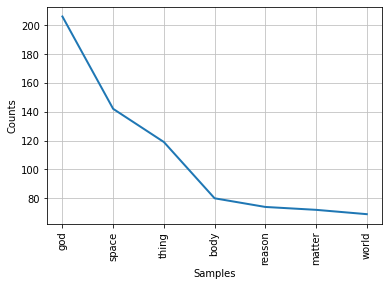

In [ ]:
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted2)
    
di_freq2.plot(7, cumulative=False)

# **STEP 2**

In [ ]:
import nltk
import string
from heapq import nlargest
from nltk.tag import pos_tag
from string import punctuation
from inspect import getsourcefile
from collections import defaultdict
from nltk.tokenize import word_tokenize
from os.path import abspath, join, dirname
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer

# Create a list with all the relations of each noun 

In [ ]:
def relation_list(nouns):

    relation_list = defaultdict(list)
    
    for k in range (len(nouns)):   
        relation = []
        for syn in wordnet.synsets(nouns[k], pos = wordnet.NOUN):
            for l in syn.lemmas():
                relation.append(l.name())
                if l.antonyms():
                    relation.append(l.antonyms()[0].name())
            for l in syn.hyponyms():
                if l.hyponyms():
                    relation.append(l.hyponyms()[0].name().split('.')[0])
            for l in syn.hypernyms():
                if l.hypernyms():
                    relation.append(l.hypernyms()[0].name().split('.')[0])
        relation_list[nouns[k]].append(relation)
    return relation_list

# Compute the lexical chain between each noun and their relation and apply a threshold of similarity between each word. 

In [ ]:
def create_lexical_chain(nouns, relation_list):
    lexical = []
    threshold = 0.5
    for noun in nouns:
        flag = 0
        for j in range(len(lexical)):
            if flag == 0:
                for key in list(lexical[j]):
                    if key == noun and flag == 0:
                        lexical[j][noun] +=1
                        flag = 1
                    elif key in relation_list[noun][0] and flag == 0:
                        syns1 = wordnet.synsets(key, pos = wordnet.NOUN)
                        syns2 = wordnet.synsets(noun, pos = wordnet.NOUN)
                        if syns1[0].wup_similarity(syns2[0]) >= threshold:
                            lexical[j][noun] = 1
                            flag = 1
                    elif noun in relation_list[key][0] and flag == 0:
                        syns1 = wordnet.synsets(key, pos = wordnet.NOUN)
                        syns2 = wordnet.synsets(noun, pos = wordnet.NOUN)
                        if syns1[0].wup_similarity(syns2[0]) >= threshold:
                            lexical[j][noun] = 1
                            flag = 1
        if flag == 0: 
            dic_nuevo = {}
            dic_nuevo[noun] = 1
            lexical.append(dic_nuevo)
            flag = 1
    return lexical

# Prune the lexical chain, deleting the chains that are more weak with just a few words. 

In [ ]:
def prune(lexical):
    final_chain = []
    while lexical:
        result = lexical.pop()
        if len(result.keys()) == 1:
            for value in result.values():
                if value != 1: 
                    final_chain.append(result)
        else:
            final_chain.append(result)
    return final_chain

# Class for finding lexical_chains in the letters

In [ ]:
"""
Class for summarize the text: 
    Input:
        text: The input text that we have read.
        lexical_chain: The final lexical chain with the most important
        n: The number of sentence we want our summary to have. 
    Output:
        The lexical_chains.
"""
class Summarizer:
    
    def __init__(self, threshold_min=0.1, threshold_max=0.9):
        self.threshold_min = threshold_min
        self.threshold_max = threshold_max 
        self._stopwords = set(stopwords.words('english') + list(punctuation ,'utterance','ref','genid','clarke','thing'))
        
        
    """ 
      Compute the frequency of each of word taking into account the 
      lexical chain and the frequency of other words in the same chain. 
      Normalize and filter the frequencies. 
    """
    def return_frequencies(self, words, lexical_chain):
        frequencies = defaultdict(int)
        for word in words:
            for w in word:
                if w not in self._stopwords:
                    flag = 0
                    for i in lexical_chain:
                        if w in list(i.keys()):
                            frequencies[w] = sum(list(i.values()))
                            flag = 1
                            break
                    if flag == 0: 
                        frequencies[w] += 1
        m = float(max(frequencies.values()))
        for w in list(frequencies.keys()):
            frequencies[w] = frequencies[w]/m
            if frequencies[w] >= self.threshold_max or frequencies[w] <= self.threshold_min:
                del frequencies[w]
        return frequencies


if __name__ == "__main__":
    
    """
    Read the letters.
    """
    in_txt = join(dirname(abspath(getsourcefile(lambda:0))) , "/content/Leibniz-Clarke Letters.xml")
    with open(in_txt, "r", encoding="utf-8" ) as f:
        input_txt = f.read() 
        f.close()
        
    """
    Return the nouns of the entire text.
    """
    position = ['NN', 'NNS', 'NNP', 'NNPS']
    
    sentence = nltk.sent_tokenize(input_txt)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [tokenizer.tokenize(w) for w in sentence]
    tagged =[pos_tag(tok) for tok in tokens]
    nouns = [word.lower() for i in range(len(tagged)) for word, pos in tagged[i] if pos in position ]
        
    relation = relation_list(nouns)
    lexical = create_lexical_chain(nouns, relation)
    final_chain = prune(lexical)
    """
    Print the lexical chain. 
    """   
    for i in range(len(final_chain)):
        print("Chain "+ str(i+1) + " : " + str(final_chain[i]))
    


Chain 1 : {'mixture': 2}
Chain 2 : {'moyen': 2}
Chain 3 : {'vulgar': 2}
Chain 4 : {'collision': 1, 'collisions': 1}
Chain 5 : {'mechanics': 3}
Chain 6 : {'impact': 2}
Chain 7 : {'cubes': 2}
Chain 8 : {'ship': 3}
Chain 9 : {'finites': 2}
Chain 10 : {'limits': 2}
Chain 11 : {'jar': 2}
Chain 12 : {'aren': 2}
Chain 13 : {'subdivision': 2}
Chain 14 : {'divisions': 1, 'division': 1}
Chain 15 : {'lip': 2}
Chain 16 : {'angel': 2}
Chain 17 : {'birth': 1, 'births': 1}
Chain 18 : {'adversaries': 2}
Chain 19 : {'qu': 2}
Chain 20 : {'par': 2}
Chain 21 : {'loss': 2}
Chain 22 : {'generator': 2}
Chain 23 : {'hors': 2}
Chain 24 : {'principe': 2}
Chain 25 : {'union': 3}
Chain 26 : {'descartes': 3}
Chain 27 : {'philosophical': 2}
Chain 28 : {'sooner': 2}
Chain 29 : {'chimeras': 1, 'monster': 1, 'imagination': 1}
Chain 30 : {'absurdity': 2}
Chain 31 : {'names': 2}
Chain 32 : {'drops': 3, 'drop': 1}
Chain 33 : {'leaves': 3}
Chain 34 : {'garden': 2}
Chain 35 : {'princess': 2}
Chain 36 : {'pair': 2}
Chain 37